In [73]:
# Data preparation for Ph.D thesis
# @author: Andres L. Suarez-Cetrulo
%config IPCompleter.greedy=True
%load_ext jupyternotify
%matplotlib inline

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [74]:
# Imports
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import os

# Using TALib abstract API to create a dictionary of technical indicators to iterate later.
from talib import abstract

In [75]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [76]:
import subprocess
# Define this to parse the CSVs to ARFF later automatically
def create_arff_file(filename, output=None):
    java_mem = '-Xmx3074m'
    filename = filename.replace('.csv', '')
    if output is None:
        output=filename
    else:
        output = output.replace('.csv', '')
    wekadev_libpath = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\lib\\weka-dev-3.7.12.jar'
    command = ['java', java_mem, '-classpath', wekadev_libpath,
               'weka.core.converters.CSVLoader', filename + '.csv', '>', output + '.arff']
    f = open(filename + '.arff', "w")
    subprocess.call(command, stdout=f)
    print('If the arff is not generated, run the next in the terminal.')
    print(str(' '.join(command)))

In [77]:
# Creating a dictionary of technical indicators using TALib abstract API
indicators = ['sma','ema','wma','mom','stoch','macd' ,'rsi' ,'willr',
              'adosc' ,'cci','adx','aroon' ,'bbands','obv' ,'trima',
              'roc' ,'rocr','stochf','medprice','typprice','wclprice',
              'atr','macdfix','mfi' ,'sar' ,'ppo']

def get_indicator(ind: str):
    return abstract.Function(ind)

# Add as many indicators as necessary: see all indicators in https://mrjbq7.github.io/ta-lib/

In [78]:
# Paths for symbols (not eft)
DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data'])
# '/Users/asuarez/Downloads'
SOURCE_PATH=DATA_PATH # +'raw\\alpha_vantage\\S&P500\\symbols\\AAPL\\'  # 'raw/alpha_vantage/'
RESULT_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output']) # +'analysis\\'+SYMBOL.lower()+'\\'

# List of dates for files to be loaded
# raw_datasets = ['aapl\\APPLE_[2018-08-01_to_2018-09-11]_5min.csv',
#                   'btc\\BITCOIN_[2019-07-01_to_2019-07-15]_5min.csv',
#                   'xrp\\RIPPLE_[2019-07-01_to_2019-08-01]_5min.csv',
#                   'efts\\5min-level\\DOWJONES\\DOWJONES_[2015-08-01_to_2015-08-31]_market_hours.csv']
# series used with synthetic set 2
# raw_datasets = ['C:\\Users\\suare\\data\\list\\whitelisted\\sets\\biv20170210T1354.csv',
#                   'C:\\Users\\suare\\data\\tmp\\selection\\spxl20180524T1550.csv',
#                   'C:\\Users\\suare\\data\\list\\whitelisted\\sets\\iwo20170607T1613.csv',
#                   'C:\\Users\\suare\\data\\tmp\\selection\\vv20171101T1523.csv']
# the one sent in nov 2020 above

# the one sent in dec 2020 below
# MANUAL SELECTION BASED ON AIC/BIC
raw_datasets = [
    'C:\\Users\\suare\\data\\tmp3\\selection\\1_equities_spy20200103T1407.csv', # equities: down trend (SPY)
    'C:\\Users\\suare\\data\\tmp3\\selection\\2_fixed_pref_pff20200106T1302.csv',  # fixed-income pref: up trend (PFF)
    'C:\\Users\\suare\\data\\tmp3\\selection\\5_real_state_vnq20200106T1215.csv',  # real state: lat/down volatile trend (VNQ)
    'C:\\Users\\suare\\data\\tmp3\\selection\\3_inter_bonds_bwx20200106T1531.csv']  # Intern. bonds: lat/up flat trend (BWX)
 
# raw_datasets = ['efts\\1min-level\\DOWJONES\\DOWJONES_[2015-01-01_to_2016-01-01]_market_hours.csv']
# Processing BTC for NA.
# raw_datasets = ['btc\\BITCOIN_[2018-07-01_to_2018-10-01]_1min.csv', # Mahalanobis set
#                 'btc\\BITCOIN_[2018-10-01_to_2019-01-01]_1min.csv', # Devset
#                 'btc\\BITCOIN_[2019-01-01_to_2020-01-01]_1min.csv', # 1yr Training set
#                 'btc\\BITCOIN_[2019-01-01_to_2020-07-01]_1min.csv'] # 1.5yr training set

filename = raw_datasets[3] # 'timeseries_created_21-10-2019' # 'timeseries_created_1571527428'
FIELD = 'close' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'

# file = os.sep.join([SOURCE_PATH, filename])
file = filename
RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_indicators_best.csv'])

In [79]:
# Open file
df=pd.read_csv(file, sep=',')
print(df.head())

df['close'] = df[FIELD]
df.tail()
df = df[['datetime', 'date', 'time', 'open', 'high', 'low', 'close', 'volume']]

        datetime      date  time    open    high     low   close   volume  \
0  20200102T1001  20200102  1001  28.638  28.638  28.638  28.638  622.857   
1  20200102T1003  20200102  1003  28.638  28.638  28.638  28.638  731.355   
2  20200102T1004  20200102  1004  28.638  28.638  28.638  28.638  602.765   
3  20200102T1005  20200102  1005  28.638  28.638  28.638  28.638  602.765   
4  20200102T1006  20200102  1006  28.638  28.638  28.633  28.638  635.917   

   close_returns  SMA_1000  SMA_start_date  SMA_start_ms     datetime.1  
0            0.0       NaN             NaN           NaN  20200102T1001  
1            0.0       NaN             NaN           NaN  20200102T1003  
2            0.0       NaN             NaN           NaN  20200102T1004  
3            0.0       NaN             NaN           NaN  20200102T1005  
4            0.0       NaN             NaN           NaN  20200102T1006  


,datetime,date,time,open,high,low,close,volume,close_returns,SMA_1000,SMA_start_date,SMA_start_ms,datetime.1
995,20200106T1527,20200106,1527,28.7077,28.7077,28.7027,28.7027,646.968,-0.000174,NaN,NaN,NaN,20200106T1527
996,20200106T1528,20200106,1528,28.7077,28.7077,28.6978,28.7027,41942.400,0.000000,NaN,NaN,NaN,20200106T1528
997,20200106T1529,20200106,1529,28.7027,28.7077,28.6979,28.7077,734.369,0.000174,NaN,NaN,NaN,20200106T1529
998,20200106T1530,20200106,1530,28.6998,28.7077,28.6998,28.7077,4409.230,0.000000,NaN,NaN,NaN,20200106T1530
999,20200106T1531,20200106,1531,28.7077,28.7077,28.7027,28.7027,2762.670,-0.000174,0.000002,NaN,NaN,20200106T1531


In [80]:
#Add parameters to transform in TS
timeseries=['close', 'open', 'high', 'low']
#Length of the TS. How many values do we keep per serie. 
# e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
length = 5

# Add lagged times
for column in timeseries:
    #df[column+'_t']=df[column]
    for i in range(1,length):
        df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed
    #del drops the delected df column
    #del df[column]
df.head()

,datetime,date,time,open,high,low,close,volume,close_t-1,close_t-2,...,open_t-3,open_t-4,high_t-1,high_t-2,high_t-3,high_t-4,low_t-1,low_t-2,low_t-3,low_t-4
0,20200102T1001,20200102,1001,28.638,28.638,28.638,28.638,622.857,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20200102T1003,20200102,1003,28.638,28.638,28.638,28.638,731.355,28.638,NaN,...,NaN,NaN,28.638,NaN,NaN,NaN,28.638,NaN,NaN,NaN
2,20200102T1004,20200102,1004,28.638,28.638,28.638,28.638,602.765,28.638,28.638,...,NaN,NaN,28.638,28.638,NaN,NaN,28.638,28.638,NaN,NaN
3,20200102T1005,20200102,1005,28.638,28.638,28.638,28.638,602.765,28.638,28.638,...,28.638,NaN,28.638,28.638,28.638,NaN,28.638,28.638,28.638,NaN
4,20200102T1006,20200102,1006,28.638,28.638,28.633,28.638,635.917,28.638,28.638,...,28.638,28.638,28.638,28.638,28.638,28.638,28.638,28.638,28.638,28.638


In [81]:
# all the numbers here and below assume a default time period for ta params of 10 mins averages
# change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
# in that case change as well the time tag '_10' with the corresponding one.
default_timerange=10
# Set extra timeranges for moving averages
extra_timeranges=[default_timerange/2, default_timerange, default_timerange*2, default_timerange*3]

# ###########################################
# Iterate and run list of indicators selected
# All of them produced for 25 prior mins of data 
# ###########################################
for ind in list(indicators):
    if ind not in ['adosc', 'obv', 'mfi']:  # avoiding indicators that need volume
        # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
        if ind in ['ema','sma','trima']:
            for timerange in extra_timeranges:
                df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
        elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
            df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
        # Otherwise check the list of columns and return all
        else: 
            key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
            for j in range(0,len(list(key_output.columns))):
                df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]
df.head()

,datetime,date,time,open,high,low,close,volume,close_t-1,close_t-2,...,stochf_fastd,medprice_10,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10
0,20200102T1001,20200102,1001,28.638,28.638,28.638,28.638,622.857,NaN,NaN,...,NaN,28.6380,28.638000,28.63800,NaN,NaN,NaN,NaN,NaN,NaN
1,20200102T1003,20200102,1003,28.638,28.638,28.638,28.638,731.355,28.638,NaN,...,NaN,28.6380,28.638000,28.63800,NaN,NaN,NaN,NaN,28.638,NaN
2,20200102T1004,20200102,1004,28.638,28.638,28.638,28.638,602.765,28.638,28.638,...,NaN,28.6380,28.638000,28.63800,NaN,NaN,NaN,NaN,28.638,NaN
3,20200102T1005,20200102,1005,28.638,28.638,28.638,28.638,602.765,28.638,28.638,...,NaN,28.6380,28.638000,28.63800,NaN,NaN,NaN,NaN,28.638,NaN
4,20200102T1006,20200102,1006,28.638,28.638,28.633,28.638,635.917,28.638,28.638,...,NaN,28.6355,28.636333,28.63675,NaN,NaN,NaN,NaN,28.633,NaN


In [82]:
def set_label(row):
    if row['close_t+1'] > row['close']: return 1
    else: return 0

# One minute ahead closing price
df['close_t+1']=df['close'].shift(-1)

# Creating label/y to be predicted / independent (predicted) feature 'y' 
df['label'] = df.apply(set_label, axis=1)
# df.drop(columns=['n_row', 'new_switch', 'cur_switch', 'current_model_id', 'new_model_id', 
#                  'weights', 'ts', 'ret_ts', 'ts_n1_pre', 'ts_n2_pre', 'ts_n1_post', 'ts_n2_post'], inplace=True)
df.dropna(inplace=True)
df.head()

,datetime,date,time,open,high,low,close,volume,close_t-1,close_t-2,...,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10,close_t+1,label
33,20200102T1039,20200102,1039,28.6729,28.6828,28.6719,28.6719,4979.840,28.6723,28.6727,...,28.675533,28.674625,0.004761,0.008073,0.008031,0.000042,28.654664,0.026183,28.6729,1
34,20200102T1040,20200102,1040,28.6729,28.6778,28.6729,28.6729,643.954,28.6719,28.6723,...,28.674533,28.674125,0.004875,0.007899,0.008004,-0.000106,28.656352,0.027607,28.6729,0
35,20200102T1041,20200102,1041,28.6729,28.6729,28.6729,28.6729,144.664,28.6729,28.6719,...,28.672900,28.672900,0.004387,0.007672,0.007938,-0.000266,28.657939,0.028599,28.6729,0
36,20200102T1042,20200102,1042,28.6729,28.6775,28.6723,28.6729,1637.510,28.6729,28.6729,...,28.674233,28.673900,0.004469,0.007408,0.007832,-0.000424,28.659431,0.029618,28.6729,0
37,20200102T1043,20200102,1043,28.6729,28.6729,28.6680,28.6729,151.696,28.6729,28.6729,...,28.671267,28.671675,0.004512,0.007117,0.007689,-0.000572,28.660833,0.027729,28.6721,0


In [83]:
# Select columns for output
# columns_selected=['rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
#                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
#                  'trima_10','trima_20','trima_30',
#                  'roc_10','rocr_10','ppo_10',
#                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  'label']
# df['label'] = df['binary_label']
fullset = False
if fullset:
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_fullset.csv'])
    columns_selected=[# 'datetime',
                     'rsi_10','willr_10','macd_macd' ,'cci_10','mom_10',
                     'stoch_slowk','stoch_slowd',
                     'sma_5','sma_10','sma_20','sma_30',
                     'wma_5','wma_10','wma_20','wma_30',
                     'ema_5','ema_10','ema_20','ema_30',
                     'trima_5','trima_10','trima_20','trima_30',
                     'adx_10','bbands_upperband','bbands_middleband','bbands_lowerband',
                     'roc_10','rocr_10','stochf_fastd','stochf_fastk',
                     'aroon_aroondown','aroon_aroonup','medprice_10','typprice_10','wclprice_10',
                     'atr_10','macdfix_macd','sar_10',
                     'adosc_10', 'obv_10', 'mfi_10', 'ppo_10', ########## commented out previosly
                     'volume','volume_t-1','volume_t-2','volume_t-3','volume_t-4',
                     'close','close_t-1','close_t-2','close_t-3','close_t-4',
                     'high','high_t-1','high_t-2','high_t-3','high_t-4',
                     'open','open_t-1','open_t-2','open_t-3','open_t-4',
                     'low','low_t-1','low_t-2','low_t-3','low_t-4',
                     # 'binary_label',
                     'label'] #,'gap_t+1','close_t+1'] # + ['adosc_10', 'obv_10', 'mfi_10', 'ppo_10']
    
else:  # the ones used with the synthetic set due to the lack of volumes also
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_indicators_best.csv'])
    # best pool found through indicators grid search script
    columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                        'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                        'aroon_aroondown','aroon_aroonup','label']

# Export processed data
output = pd.DataFrame(df, columns=columns_selected)
output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
crypto_path = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\data\\real\\real_crypto\\'
create_arff_file(RESULT_FILEPATH_PROCESSED, output=crypto_path+RESULT_FILEPATH_PROCESSED.split(os.sep)[-1]) # export in ARFF

# Printing classes distributions
print("Class distribution: ")
label_zero=len(df[df['label'] == 0])
label_one=len(df[df['label'] == 1])
#print(label_zero)
#print(label_one)
print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

%notify -m "Parsing is finished"

If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\3_inter_bonds_bwx20200106T1531_indicators_best.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\real\real_crypto\3_inter_bonds_bwx20200106T1531_indicators_best.arff
Class distribution: 
0 in 0.7298136645962733%
1 in 0.2701863354037267%


<IPython.core.display.Javascript object>

In [84]:
perc0 = label_zero/(label_one+label_zero)

<AxesSubplot:>

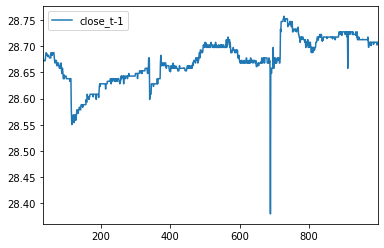

In [85]:
# Now plot close price and volume overtime.
import matplotlib.pyplot as plt
import pandas as pd

df.plot(y=["close_t-1"])
plt.savefig(filename.split(os.sep)[-1].replace('.csv', '.pdf'))
plt.show()


In [86]:
df.columns

Index(['datetime', 'date', 'time', 'open', 'high', 'low', 'close', 'volume',
       'close_t-1', 'close_t-2', 'close_t-3', 'close_t-4', 'open_t-1',
       'open_t-2', 'open_t-3', 'open_t-4', 'high_t-1', 'high_t-2', 'high_t-3',
       'high_t-4', 'low_t-1', 'low_t-2', 'low_t-3', 'low_t-4', 'sma_5',
       'sma_10', 'sma_20', 'sma_30', 'ema_5', 'ema_10', 'ema_20', 'ema_30',
       'wma_10', 'mom_10', 'stoch_slowk', 'stoch_slowd', 'macd_macd',
       'macd_macdsignal', 'macd_macdhist', 'rsi_10', 'willr_10', 'cci_10',
       'adx_10', 'aroon_aroondown', 'aroon_aroonup', 'bbands_upperband',
       'bbands_middleband', 'bbands_lowerband', 'trima_5', 'trima_10',
       'trima_20', 'trima_30', 'roc_10', 'rocr_10', 'stochf_fastk',
       'stochf_fastd', 'medprice_10', 'typprice_10', 'wclprice_10', 'atr_10',
       'macdfix_macd', 'macdfix_macdsignal', 'macdfix_macdhist', 'sar_10',
       'ppo_10', 'close_t+1', 'label'],
      dtype='object')

In [87]:
# Select columns for output
# columns_selected=['rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
#                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
#                  'trima_10','trima_20','trima_30',
#                  'roc_10','rocr_10','ppo_10',
#                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  'label']
# df['label'] = df['binary_label']
fullset = False
if fullset:
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_fullset.csv'])
    columns_selected=[# 'datetime',
                     'rsi_10','willr_10','macd_macd' ,'cci_10','mom_10',
                     'stoch_slowk','stoch_slowd',
                     'sma_5','sma_10','sma_20','sma_30',
                     'wma_5','wma_10','wma_20','wma_30',
                     'ema_5','ema_10','ema_20','ema_30',
                     'trima_5','trima_10','trima_20','trima_30',
                     'adx_10','bbands_upperband','bbands_middleband','bbands_lowerband',
                     'roc_10','rocr_10','stochf_fastd','stochf_fastk',
                     'aroon_aroondown','aroon_aroonup','medprice_10','typprice_10','wclprice_10',
                     'atr_10','macdfix_macd','sar_10',
                     'adosc_10', 'obv_10', 'mfi_10', 'ppo_10', ########## commented out previosly
                     'volume','volume_t-1','volume_t-2','volume_t-3','volume_t-4',
                     'close','close_t-1','close_t-2','close_t-3','close_t-4',
                     'high','high_t-1','high_t-2','high_t-3','high_t-4',
                     'open','open_t-1','open_t-2','open_t-3','open_t-4',
                     'low','low_t-1','low_t-2','low_t-3','low_t-4',
                     # 'binary_label',
                     'label'] #,'gap_t+1','close_t+1'] # + ['adosc_10', 'obv_10', 'mfi_10', 'ppo_10']
    
else:  # the ones used with the synthetic set due to the lack of volumes also
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_indicators_best.csv'])
    # best pool found through indicators grid search script
    columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                        'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                        'aroon_aroondown','aroon_aroonup','label']

# Export processed data
output = pd.DataFrame(df, columns=columns_selected)
output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
crypto_path = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\data\\real\\real_crypto\\'
create_arff_file(RESULT_FILEPATH_PROCESSED, output=crypto_path+RESULT_FILEPATH_PROCESSED.split(os.sep)[-1]) # export in ARFF

# Printing classes distributions
print("Class distribution: ")
label_zero=len(df[df['label'] == 0])
label_one=len(df[df['label'] == 1])
#print(label_zero)
#print(label_one)
print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

%notify -m "Parsing is finished"

If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\3_inter_bonds_bwx20200106T1531_indicators_best.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\real\real_crypto\3_inter_bonds_bwx20200106T1531_indicators_best.arff
Class distribution: 
0 in 0.7298136645962733%
1 in 0.2701863354037267%


<IPython.core.display.Javascript object>

In [165]:
RESULT_FILEPATH_PROCESSED

'C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\output\\vv20171101T1523_indicators_best.csv'

In [166]:
df.columns

Index(['datetime', 'date', 'time', 'open', 'high', 'low', 'close', 'volume',
       'close_returns', 'SMA_1000', 'SMA_start_date', 'SMA_start_ms',
       'datetime.1', 'close_t-1', 'close_t-2', 'close_t-3', 'close_t-4',
       'open_t-1', 'open_t-2', 'open_t-3', 'open_t-4', 'high_t-1', 'high_t-2',
       'high_t-3', 'high_t-4', 'low_t-1', 'low_t-2', 'low_t-3', 'low_t-4',
       'sma_5', 'sma_10', 'sma_20', 'sma_30', 'ema_5', 'ema_10', 'ema_20',
       'ema_30', 'wma_10', 'mom_10', 'stoch_slowk', 'stoch_slowd', 'macd_macd',
       'macd_macdsignal', 'macd_macdhist', 'rsi_10', 'willr_10', 'cci_10',
       'adx_10', 'aroon_aroondown', 'aroon_aroonup', 'bbands_upperband',
       'bbands_middleband', 'bbands_lowerband', 'trima_5', 'trima_10',
       'trima_20', 'trima_30', 'roc_10', 'rocr_10', 'stochf_fastk',
       'stochf_fastd', 'medprice_10', 'typprice_10', 'wclprice_10', 'atr_10',
       'macdfix_macd', 'macdfix_macdsignal', 'macdfix_macdhist', 'sar_10',
       'ppo_10', 'close_t+1', '